In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm

In [2]:
import sys, os
sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2

from modules.config import *
from modules.preprocessing import calculate_availability

In [3]:
movements_grouped = pd.read_parquet(MOVEMENTS_GROUPED_SPATIO_TEMPORAL_PATH)
movements = pd.read_parquet(MOVEMENTS_PATH)

In [4]:
movements_grouped = movements_grouped.rename({'demand': 'n_bikes'}, axis=1)
movements_grouped.head(2)

,datetime_start_floored,datetime_end_floored,start_hex_id,end_hex_id,n_bikes,h3_res,time_interval_length
index,,,,,,,
0,2019-01-20,2019-01-20,871f1a164ffffff,871f1a164ffffff,2,7,1
1,2019-01-20,2019-01-20,871f1a164ffffff,871f1a8cbffffff,1,7,1


In [5]:
movements = movements.sort_values('datetime_start')
first_locations = movements.groupby('b_number').first().reset_index()
movements = movements.sort_values('datetime_end')
last_locations = movements.groupby('b_number').last().reset_index()

In [6]:
movements_grouped_spec = movements_grouped[
    (movements_grouped["h3_res"] == H3_RESOLUTION)
    & (movements_grouped["time_interval_length"] == TIME_INTERVAL_LENGTH)
]
movements_grouped_spec = movements_grouped_spec.drop(
    columns=["h3_res", "time_interval_length"]
)
movements_grouped_spec.head(2)


,datetime_start_floored,datetime_end_floored,start_hex_id,end_hex_id,n_bikes
index,,,,,
0,2019-01-20,2019-01-20,881f1a1601fffff,881f1a1601fffff,4
1,2019-01-20,2019-01-20,881f1a1601fffff,881f1a1659fffff,3


In [7]:
first_locations = first_locations.rename(
    columns={"lat_start": "lat", "lng_start": "lng", "datetime_start": "datetime"}
)
# drop all except
last_locations = last_locations.rename(
    columns={"lat_end": "lat", "lng_end": "lng", "datetime_end": "datetime"}
)


We now calculate the availability of bicycles per hexagon and time interval.  
Intuitively, our approach can be described by the following steps:
1. Spawn/create each bicycle in the hexagon where it is first seen at the
correct time to get a base number for the availability (+1 for hexagon at
specific time interval).
2. update the availability at each hexagon and time interval as described by the
entries in `movements_grouped` (+incoming bikes, -outgoing bikes for each
hexagon at each time interval).  
3. despawn/remove each bicycles in the hexagon where it is last seen at the
correct time (-1 for hexagon at specific time interval).

In [8]:
availability = calculate_availability(
    movements_grouped_spec,
    first_locations,
    last_locations,
    H3_RESOLUTION,
    TIME_INTERVAL_LENGTH,
)


In [9]:
ar = availability.reset_index()

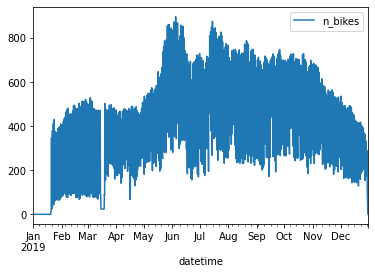

In [10]:
ar.groupby('datetime').sum().plot()
plt.show()

In [11]:
results = {}
for h3_res, time_interval_length in tqdm(
    list(itertools.product(CALC_H3_RESOLUTIONS, CALC_TIME_INTERVAL_LENGTHS))
):
    movements_grouped_spec = movements_grouped[
        (movements_grouped["h3_res"] == h3_res)
        & (movements_grouped["time_interval_length"] == time_interval_length)
    ]
    movements_grouped_spec = movements_grouped_spec.drop(
        columns=["h3_res", "time_interval_length"]
    )
    results[(h3_res, time_interval_length)] = calculate_availability(
        movements_grouped_spec,
        first_locations,
        last_locations,
        h3_res,
        time_interval_length,
    )


  0%|          | 0/12 [00:00<?, ?it/s]

In [12]:
availability = pd.concat(results)

In [13]:
availability.index.names = ['h3_res', 'time_interval_length', 'datetime', 'hex_id']

In [14]:
ar = availability.xs((8,1)).reset_index()

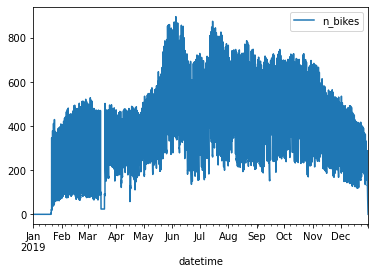

In [15]:
ar.groupby('datetime').sum().plot()
plt.show()

In [16]:
ar.n_bikes.max()

70

In [17]:
availability.head(3)

n_bikes
h3_res time_interval_length datetime   hex_id                  
7      1                    2019-01-01 871f1a140ffffff        0
                                       871f1a144ffffff        0
                                       871f1a145ffffff        0